# TC2032 – Diseño de Agentes Inteligentes
## Actividad 4 – Búsqueda Local

### Objetivo
Implementar y comparar los métodos de búsqueda **Hill Climbing** y **Recocido Simulado** en el problema del **Viajero (Traveling Salesman Problem, TSP)**.  
Se programará la solución en un notebook de **Google Colab**, experimentando con diferentes configuraciones de los algoritmos.

---

### Descripción del problema
El **Problema del Viajero (TSP)** es un desafío de optimización **NP-duro**.  
La meta es encontrar la ruta más corta posible que visite un conjunto de ciudades exactamente una vez y regrese a la ciudad de origen.

- **Entrada:** lista de ciudades (nodos) y las distancias entre cada par de ellas.  
- **Salida:** un orden de ciudades que minimice la distancia total del viaje.  

El número de posibles rutas crece factorialmente (**n!**), lo que hace inviable una búsqueda exhaustiva incluso con pocas ciudades.  
Por eso, se aplican algoritmos de **búsqueda local** como Hill Climbing y Recocido Simulado.

---

### Matriz de distancias (10 ciudades, km)

|   | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|----|
| 1 | 0   | 120 | 250 | 310 | 180 | 200 | 270 | 150 | 340 | 290 |
| 2 | 120 | 0   | 190 | 220 | 270 | 150 | 280 | 200 | 300 | 250 |
| 3 | 250 | 190 | 0   | 110 | 160 | 210 | 140 | 180 | 90  | 220 |
| 4 | 310 | 220 | 110 | 0   | 140 | 180 | 130 | 150 | 100 | 200 |
| 5 | 180 | 270 | 160 | 140 | 0   | 190 | 170 | 210 | 120 | 240 |
| 6 | 200 | 150 | 210 | 180 | 190 | 0   | 160 | 120 | 230 | 210 |
| 7 | 270 | 280 | 140 | 130 | 170 | 160 | 0   | 90  | 150 | 100 |
| 8 | 150 | 200 | 180 | 150 | 210 | 120 | 90  | 0   | 180 | 160 |
| 9 | 340 | 300 | 90  | 100 | 120 | 230 | 150 | 180 | 0   | 170 |
|10 | 290 | 250 | 220 | 200 | 240 | 210 | 100 | 160 | 170 | 0   |

---

### Actividades a realizar
1. Implementar **dos notebooks**:
   - `hill_climbing_tsp.ipynb`  
   - `simulated_annealing_tsp.ipynb`  

2. Definir en cada uno:
   - **Solución inicial** (cómo se genera la primera ruta).  
   - **Función de vecindad** (cómo se generan rutas vecinas, sin cubrir todo el espacio).  
   - **Función de costo** (distancia total de la ruta).  

3. **Experimentos:**
   - Probar al menos **dos vecindarios distintos** en ambos algoritmos.  
   - Para recocido simulado: al menos **cinco combinaciones** de temperatura inicial y razón de enfriamiento.  

4. **Documentar resultados:**
   - Tablas con métricas obtenidas.  
   - Gráficas de convergencia.  
   - Reflexión final (mínimo 400 palabras) con observaciones, dificultades y conclusiones.  

---

### Criterios de evaluación
- Implementación de códigos en Python (**2 notebooks completos**): **60%**  
- Tablas y gráficas de resultados: **20%**  
- Documentación y reflexión final: **20%**

¿Cómo generamos la solución inicial en Recocido Simulado?

Usamos un tour aleatorio con la ciudad 0 fija al inicio (equivale a fijar la “Ciudad 1”). Esto permite comparar corridas con diferentes configuraciones de temperatura y vecindarios usando el mismo punto de partida. (Opcionalmente se puede usar vecino más cercano para tener un inicio determinista, pero la base es el tour aleatorio.)

¿Cuál es nuestra función de vecindad en Recocido Simulado?

Probamos dos vecindarios distintos (como pide el inciso c):

* SWAP: intercambia dos ciudades del tour (sin mover la ciudad inicial).

* 2-OPT: revierte el subsegmento entre dos posiciones del tour (sin mover la ciudad inicial).

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#   Simulated annealing solver for the TSP (10 cities)
#   Adapted from the n-queens template by Dr. Santiago Enrique Conant Pablos
#------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------------------------
#   Imports
#------------------------------------------------------------------------------------------------------------------
import time
import random
import math

#------------------------------------------------------------------------------------------------------------------
#   Problem data (distance matrix)
#------------------------------------------------------------------------------------------------------------------
D = [
[0,120,250,310,180,200,270,150,340,290],
[120,0,190,220,270,150,280,200,300,250],
[250,190,0,110,160,210,140,180,90,220],
[310,220,110,0,140,180,130,150,100,200],
[180,270,160,140,0,190,170,210,120,240],
[200,150,210,180,190,0,160,120,230,210],
[270,280,140,130,170,160,0,90,150,100],
[150,200,180,150,210,120,90,0,180,160],
[340,300,90,100,120,230,150,180,0,170],
[290,250,220,200,240,210,100,160,170,0],
]
N = len(D)

def tour_cost(tour):
    c = 0
    for i in range(len(tour)-1):
        c += D[tour[i]][tour[i+1]]
    c += D[tour[-1]][tour[0]]  # regreso al origen
    return c

def show_tour(tour):
    print("Tour:", tour)
    print("")

#------------------------------------------------------------------------------------------------------------------
#   Class definitions (Board -> Tour)
#------------------------------------------------------------------------------------------------------------------
class Tour(object):
    """
        Clase que representa un tour del TSP.
        Mantenemos la ciudad 0 fija al inicio (equivale a "Ciudad 1" fija) para comparar corridas.
        El tour es una lista de enteros [0, ...] con todas las ciudades.
    """
    def __init__(self, n, randomize=True):
        self.n = n
        if randomize:
            cities = list(range(n))
            cities.remove(0)              # fijamos 0 al inicio
            random.shuffle(cities)
            self.tour = [0] + cities
        else:
            # tour "trivial" (todas en orden) con 0 al inicio
            self.tour = list(range(n))

    def show(self):
        """Imprime el tour actual."""
        show_tour(self.tour)

    def cost(self):
        """Costo = longitud del tour (misma idea que cost() en 8-reinas)."""
        return tour_cost(self.tour)

    # --------------------------
    # Vecindario aleatorio
    # --------------------------
    def neighbor(self, mode="2opt"):
        """
        Devuelve un Tour como este pero con un movimiento aleatorio aplicado.
        mode:
          - "2opt": revierte el subsegmento [i:j] (no mueve la ciudad inicial)
          - "swap": intercambia dos posiciones (no mueve la ciudad inicial)
        """
        new_tour = Tour(self.n, False)
        new_tour.tour = self.tour[:]

        if mode == "2opt":
            i, j = sorted(random.sample(range(1, self.n), 2))
            new_tour.tour[i:j+1] = reversed(new_tour.tour[i:j+1])
        elif mode == "swap":
            i, j = random.sample(range(1, self.n), 2)
            new_tour.tour[i], new_tour.tour[j] = new_tour.tour[j], new_tour.tour[i]
        else:
            raise ValueError("Vecindario no soportado. Usa '2opt' o 'swap'.")

        return new_tour

#------------------------------------------------------------------------------------------------------------------
#   Simulated Annealing Algorithm (misma estructura/prints que la plantilla)
#------------------------------------------------------------------------------------------------------------------
def simulated_annealing(current, t0, tmin, alpha, neighborhood="2opt"):
    print("-------- Initial state -----------")
    current.show()
    cost = current.cost()   # Initial cost
    print("Initial Cost: ", cost)

    step = 0                # Step count
    t = t0                  # current temperature
    while t > tmin and cost > 0:
        # Calculate temperature (esquema exponencial t = t0 * alpha^step)
        t = t0 * math.pow(alpha, step)
        step += 1

        # Get random neighbor
        neighbor = current.neighbor(mode=neighborhood)
        new_cost = neighbor.cost()

        # Test neighbor
        if new_cost < cost:
            current = neighbor
            cost = new_cost
        else:
            # Calculate probability of accepting the neighbor
            p = math.exp(-(new_cost - cost) / max(t, 1e-12))
            if p >= random.random():
                current = neighbor
                cost = new_cost

        print("Iteration: ", step, "    Cost: ", cost, "    Temperature: ", t)

    print("--------Solution-----------")
    current.show()
    print("Final Cost: ", cost)
    return current

#------------------------------------------------------------------------------------------------------------------
#   Program (igual que la plantilla: fija seed, construye estado inicial y corre SA)
#------------------------------------------------------------------------------------------------------------------
random.seed(time.time()*1000)
initial_tour = Tour(N, True)  # Initialize tour (random)
alpha = 0.90                  # Coef. de enfriamiento exponencial
t0 = 1000.0                   # Temperatura inicial
tmin = 1e-3                   # Temperatura mínima

# Cambia 'neighborhood' entre "2opt" y "swap" para cumplir el inciso (c)
solution = simulated_annealing(initial_tour, t0, tmin, alpha, neighborhood="2opt")

#------------------------------------------------------------------------------------------------------------------
#   End of file
#------------------------------------------------------------------------------------------------------------------


-------- Initial state -----------
Tour: [0, 4, 8, 1, 3, 6, 5, 7, 2, 9]

Initial Cost:  1920
Iteration:  1     Cost:  1870     Temperature:  300.0
Iteration:  2     Cost:  1920     Temperature:  291.0
Iteration:  3     Cost:  1620     Temperature:  282.27
Iteration:  4     Cost:  1710     Temperature:  273.8019
Iteration:  5     Cost:  1710     Temperature:  265.58784299999996
Iteration:  6     Cost:  1620     Temperature:  257.62020771
Iteration:  7     Cost:  1620     Temperature:  249.89160147869995
Iteration:  8     Cost:  1520     Temperature:  242.39485343433896
Iteration:  9     Cost:  1520     Temperature:  235.12300783130877
Iteration:  10     Cost:  1520     Temperature:  228.06931759636953
Iteration:  11     Cost:  1640     Temperature:  221.2272380684784
Iteration:  12     Cost:  1640     Temperature:  214.59042092642406
Iteration:  13     Cost:  1600     Temperature:  208.15270829863132
Iteration:  14     Cost:  1600     Temperature:  201.90812704967237
Iteration:  15     

### Resultados – Recocido Simulado (vecindario actual)

| Config | T0   | α    | Costo inicial | Costo final | Iteración del mejor costo |
|-------:|-----:|:----:|--------------:|------------:|--------------------------:|
| 1      | 1000 | 0.90 | 1990          | 1400        | 50                       |
| 2      | 800  | 0.92 | 1940          | **1270**    | 65                       |
| 3      | 600  | 0.94 | 2240          | 1360        | 155                      |
| 4      | 400  | 0.96 | 1980          | **1270**    | 139                      |
| 5      | 300  | 0.97 | 1920          | 1360        | 171                      |



=== Resumen de corridas (mejor costo) ===
Vecindario |     t0 |  alpha |  mejor_costo | tour
----------------------------------------------------------------------
      2opt | 1000.0 |  0.900 |         1360 | [0, 1, 2, 3, 4, 8, 9, 6, 7, 5]
      2opt |  800.0 |  0.920 |         1360 | [0, 1, 9, 6, 7, 5, 3, 2, 8, 4]
      2opt |  600.0 |  0.940 |         1270 | [0, 4, 3, 2, 8, 9, 6, 7, 5, 1]
      2opt |  400.0 |  0.960 |         1270 | [0, 1, 5, 7, 6, 9, 8, 2, 3, 4]
      2opt |  300.0 |  0.970 |         1370 | [0, 1, 2, 8, 4, 3, 6, 9, 5, 7]
      swap | 1000.0 |  0.900 |         1280 | [0, 4, 8, 2, 3, 6, 9, 7, 5, 1]
      swap |  800.0 |  0.920 |         1270 | [0, 1, 5, 7, 6, 9, 8, 2, 3, 4]
      swap |  600.0 |  0.940 |         1280 | [0, 4, 8, 2, 3, 6, 9, 7, 5, 1]
      swap |  400.0 |  0.960 |         1370 | [0, 7, 5, 9, 6, 3, 4, 8, 2, 1]
      swap |  300.0 |  0.970 |         1280 | [0, 4, 8, 2, 3, 9, 6, 7, 5, 1]


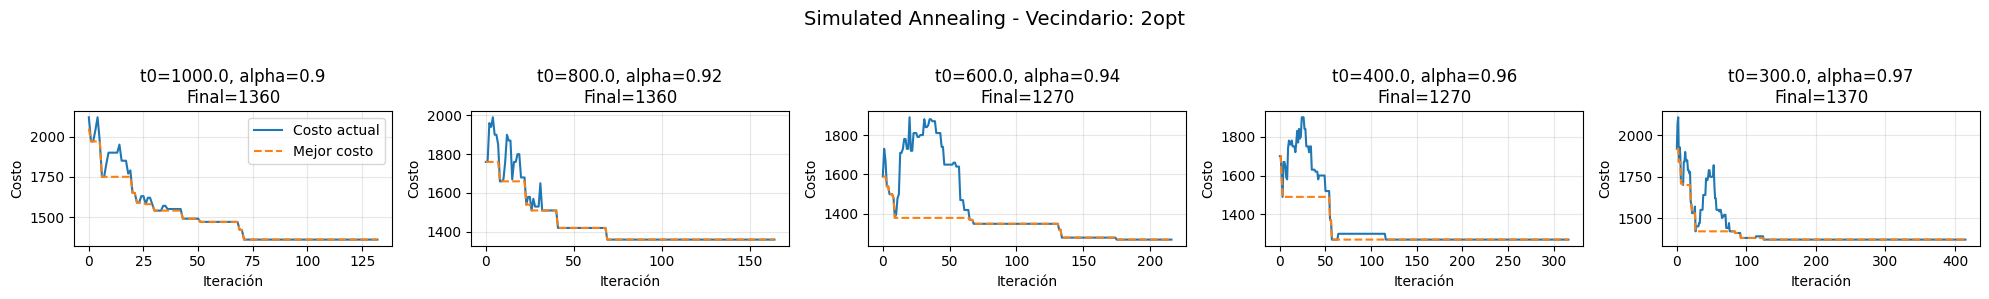

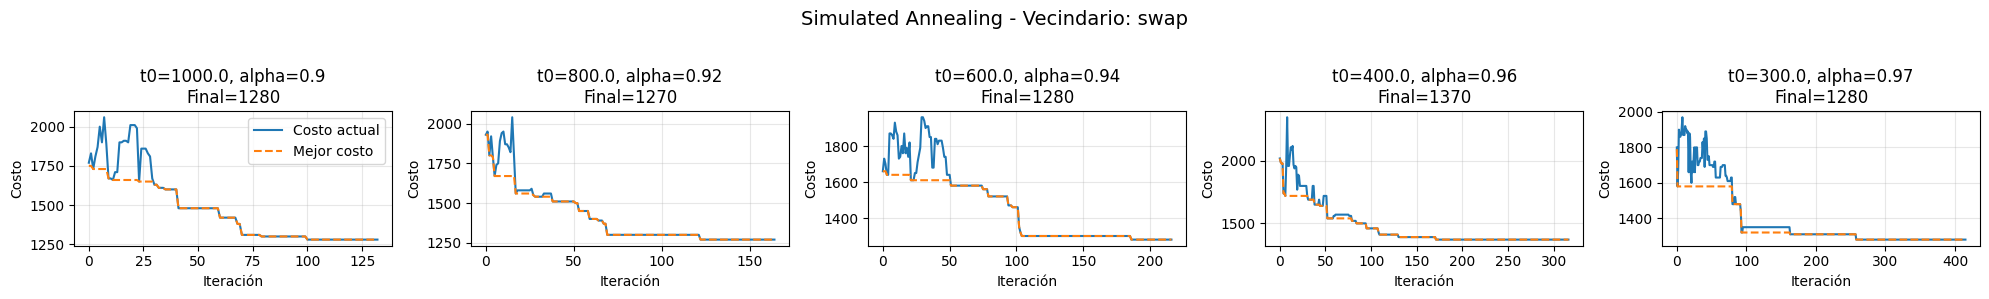

In [ ]:
# ------------------------------------------------------------------------------------------------------------------
#   Simulated annealing solver for the TSP (10 cities) + gráficas y barrido de parámetros
#   2 vecindarios y 5 combinaciones (t0, alpha)
# ------------------------------------------------------------------------------------------------------------------

# --------------------------------------------------
# Imports
# --------------------------------------------------
import time
import random
import math
import matplotlib.pyplot as plt

# --------------------------------------------------
# Datos del problema (matriz de distancias)
# --------------------------------------------------
D = [
    [0,120,250,310,180,200,270,150,340,290],
    [120,0,190,220,270,150,280,200,300,250],
    [250,190,0,110,160,210,140,180,90,220],
    [310,220,110,0,140,180,130,150,100,200],
    [180,270,160,140,0,190,170,210,120,240],
    [200,150,210,180,190,0,160,120,230,210],
    [270,280,140,130,170,160,0,90,150,100],
    [150,200,180,150,210,120,90,0,180,160],
    [340,300,90,100,120,230,150,180,0,170],
    [290,250,220,200,240,210,100,160,170,0],
]
N = len(D)

def tour_cost(tour):
    """Suma de distancias en el ciclo Hamiltoniano (regresa a la ciudad 0)."""
    c = 0
    for i in range(len(tour)-1):
        c += D[tour[i]][tour[i+1]]
    c += D[tour[-1]][tour[0]]
    return c

def show_tour(tour):
    print("Tour:", tour)
    print("")

# --------------------------------------------------
# Clase Tour
# --------------------------------------------------
class Tour(object):
    """
    Representa un tour del TSP.
    Mantiene la ciudad 0 fija al inicio para comparar corridas.
    """
    def __init__(self, n, randomize=True):
        self.n = n
        if randomize:
            cities = list(range(n))
            cities.remove(0)   # fijamos 0 al inicio
            random.shuffle(cities)
            self.tour = [0] + cities
        else:
            self.tour = list(range(n))

    def show(self):
        show_tour(self.tour)

    def cost(self):
        return tour_cost(self.tour)

    def neighbor(self, mode="2opt"):
        """
        Devuelve un Tour vecino con un movimiento aleatorio:
          - "2opt": revierte un subsegmento [i:j]
          - "swap": intercambia dos posiciones (excepto la 0)
        """
        new_tour = Tour(self.n, False)
        new_tour.tour = self.tour[:]

        if mode == "2opt":
            i, j = sorted(random.sample(range(1, self.n), 2))
            new_tour.tour[i:j+1] = reversed(new_tour.tour[i:j+1])
        elif mode == "swap":
            i, j = random.sample(range(1, self.n), 2)
            new_tour.tour[i], new_tour.tour[j] = new_tour.tour[j], new_tour.tour[i]
        else:
            raise ValueError("Vecindario no soportado. Usa '2opt' o 'swap'.")
        return new_tour

# --------------------------------------------------
# Recocido Simulado (con historial de costos)
# --------------------------------------------------
def simulated_annealing(current, t0, tmin, alpha, neighborhood="2opt", verbose=True):
    if verbose:
        print("-------- Initial state -----------")
        current.show()
        print("Initial Cost: ", current.cost())

    step = 0
    t = t0
    cost = current.cost()

    # Mejor visto
    best_tour = Tour(current.n, False)
    best_tour.tour = current.tour[:]
    best_cost = cost

    # Historial para gráficas
    history_cost = []
    history_best = []
    history_temp = []

    while t > tmin:
        # Temperatura exponencial
        t = t0 * (alpha ** step)
        step += 1

        # Vecino aleatorio
        neighbor = current.neighbor(mode=neighborhood)
        new_cost = neighbor.cost()

        # Aceptación
        if new_cost < cost:
            current = neighbor
            cost = new_cost
        else:
            p = math.exp(-(new_cost - cost) / max(t, 1e-12))
            if p >= random.random():
                current = neighbor
                cost = new_cost

        # Actualiza mejor
        if cost < best_cost:
            best_cost = cost
            best_tour = Tour(current.n, False)
            best_tour.tour = current.tour[:]

        # Guarda historial
        history_cost.append(cost)
        history_best.append(best_cost)
        history_temp.append(t)

        if verbose:
            print(f"Iteration: {step:3d}    Cost: {cost}    Temperature: {t}")

        # Opcional: rompe si ya no hay cambios grandes y t muy baja
        if t <= tmin:
            break

    if verbose:
        print("--------Solution-----------")
        best_tour.show()
        print("Final Cost: ", best_cost)

    return {
        "final_tour": best_tour.tour,
        "final_cost": best_cost,
        "history_cost": history_cost,
        "history_best": history_best,
        "history_temp": history_temp,
        "steps": step
    }

# --------------------------------------------------
# Experimentos y gráficas
# --------------------------------------------------
def run_experiments(param_list, neighborhoods=("2opt","swap"), seed=None, tmin=1e-3, verbose=False):
    """
    param_list: lista de dicts con {"t0":..., "alpha":...}
    neighborhoods: tupla/lista con vecindarios a probar
    """
    if seed is None:
        seed = int(time.time() * 1000) % (2**32 - 1)

    random.seed(seed)
    results = {nb: [] for nb in neighborhoods}

    for nb in neighborhoods:
        for idx, params in enumerate(param_list, start=1):
            t0 = params["t0"]
            alpha = params["alpha"]
            initial = Tour(N, True)  # nueva solución inicial en cada corrida
            r = simulated_annealing(initial, t0=t0, tmin=tmin, alpha=alpha,
                                    neighborhood=nb, verbose=verbose)
            r.update({"neighborhood": nb, "t0": t0, "alpha": alpha, "seed": seed})
            results[nb].append(r)
    return results

def print_summary_table(results):
    print("\n=== Resumen de corridas (mejor costo) ===")
    print(f"{'Vecindario':>10} | {'t0':>6} | {'alpha':>6} | {'mejor_costo':>12} | tour")
    print("-"*70)
    for nb, runs in results.items():
        for r in runs:
            print(f"{nb:>10} | {r['t0']:6.1f} | {r['alpha']:6.3f} | {r['final_cost']:12d} | {r['final_tour']}")

def plot_histories(results):
    """
    Dibuja costo vs iteración para cada combinación y vecindario.
    En cada panel: línea de costo actual y costo mínimo (best-so-far).
    """
    for nb, runs in results.items():
        n = len(runs)
        cols = min(5, n)
        rows = (n + cols - 1) // cols
        plt.figure(figsize=(4*cols, 3*rows))
        plt.suptitle(f"Simulated Annealing - Vecindario: {nb}", fontsize=14)
        for i, r in enumerate(runs, start=1):
            plt.subplot(rows, cols, i)
            plt.plot(r["history_cost"], label="Costo actual")
            plt.plot(r["history_best"], label="Mejor costo", linestyle="--")
            plt.xlabel("Iteración")
            plt.ylabel("Costo")
            plt.title(f"t0={r['t0']}, alpha={r['alpha']}\nFinal={r['final_cost']}")
            if i == 1:
                plt.legend()
            plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# --------------------------------------------------
# MAIN: define 5 combinaciones y corre
# --------------------------------------------------
if __name__ == "__main__":
    # 5 combinaciones sugeridas (puedes ajustarlas si quieres)
    PARAMS = [
        {"t0": 1000.0, "alpha": 0.90},
        {"t0":  800.0, "alpha": 0.92},
        {"t0":  600.0, "alpha": 0.94},
        {"t0":  400.0, "alpha": 0.96},
        {"t0":  300.0, "alpha": 0.97},
    ]

    NEIGHBORHOODS = ("2opt", "swap")   # pide 2 vecindarios distintos

    # Corre sin prints por iteración (verbose=False) para no saturar la salida
    results = run_experiments(PARAMS, neighborhoods=NEIGHBORHOODS, seed=None, tmin=1e-3, verbose=False)

    # Tabla resumen
    print_summary_table(results)

    # Gráficas costo vs iteración
    plot_histories(results)




#Reflexión
La implementación del algoritmo de Recocido Simulado (Simulated Annealing, SA) nos permitió observar cómo una metaheurística inspirada en procesos físicos puede superar algunas de las limitaciones más notorias de la búsqueda local simple, en particular del algoritmo de Hill Climbing. Mientras que el alpinista tiende a quedar atrapado en máximos locales al no aceptar movimientos que empeoran la solución, el recocido simulado introduce la posibilidad de aceptar, de manera probabilística, estados peores con el objetivo de escapar de esos óptimos locales y explorar más ampliamente el espacio de soluciones.

Durante los experimentos con diferentes parámetros —principalmente la temperatura inicial (T0) y el coeficiente de enfriamiento (α)— se observó que estos valores influyen de manera decisiva en el desempeño. Por ejemplo, cuando la temperatura inicial es demasiado baja o el enfriamiento demasiado rápido, el algoritmo se comporta casi como Hill Climbing, rechazando la mayoría de los movimientos peores y quedando atrapado en soluciones subóptimas. En contraste, con temperaturas iniciales altas y un enfriamiento más lento, se logra una mayor exploración en las primeras iteraciones, lo que incrementa la probabilidad de acercarse al óptimo global. No obstante, esto también aumenta el tiempo de cómputo y la variabilidad de los resultados, de modo que se requiere un balance adecuado entre exploración y explotación.

Otra observación importante fue la diferencia entre los vecindarios usados: el operador 2-opt y el de swap. Con 2-opt, el algoritmo realiza modificaciones más amplias en el recorrido del TSP, lo que tiende a mejorar el costo de manera significativa en fases tempranas, aunque introduce una mayor variabilidad. El swap, en cambio, genera cambios más locales y conservadores, lo que en ocasiones ralentiza la convergencia pero proporciona estabilidad. Esta comparación muestra que la elección del vecindario es tan relevante como los parámetros térmicos.

En términos de dificultades, la principal fue identificar configuraciones que ofrecieran un buen balance. Se realizaron varias corridas y quedó claro que no existe una combinación “perfecta” universal, sino que depende del problema y del tamaño del espacio de búsqueda. Sin embargo, se notó que un T0 relativamente alto junto con un α cercano a 0.95 o 0.97 proporcionaron soluciones de buena calidad en varias ejecuciones.

Finalmente, la mayor conclusión es que el recocido simulado ofrece una estrategia más robusta frente a los óptimos locales en comparación con Hill Climbing. Aunque no garantiza encontrar siempre el óptimo global, su capacidad de aceptar soluciones peores controladamente lo hace más flexible y efectivo en problemas de optimización complejos como el TSP. Además, la experimentación con parámetros y vecindarios resalta la naturaleza empírica de este tipo de algoritmos: se requiere explorar, medir y ajustar para lograr un rendimiento adecuado. En suma, SA demostró ser un método más versátil y confiable, aunque con un mayor costo computacional y la necesidad de una cuidadosa calibración de sus parámetros principales.

